In [24]:
import BOX_1 as B
import numpy as np
import matplotlib.pyplot as plt

In [25]:
step_tot = 10**7
check_step = 1000

In [26]:
box = B.BOX(128,210,0.,0.,[2.5,0.],0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    moves = np.array(box.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(box.cluster_size())

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7f28488ab2e0>
Traceback (most recent call last):
  File "/media/hcleroy/anaconda3/lib/python3.11/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


: 

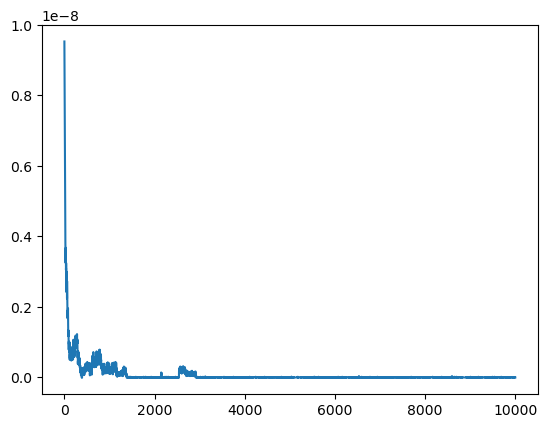

In [4]:
plt.plot(acceptance)

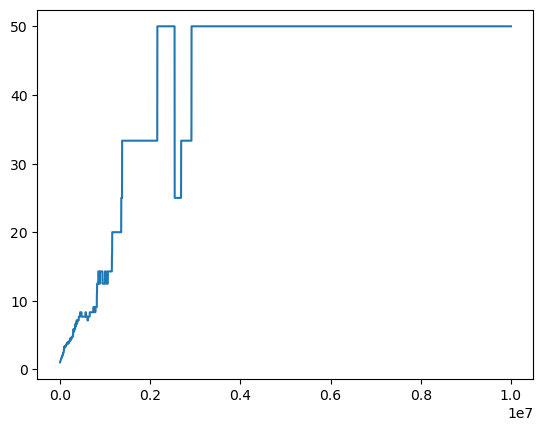

In [5]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [6]:
box.cluster_size()

array([91,  9])

In [10]:
import numpy as np
import MC_frontend
step_tot = 10**7
check_step = 1000


In [11]:
mc = MC_frontend.MC(128,210,0,0,[[0.,0.,0.],[0.,2.5,0.],[0.,0.,0.]],0.,0.1)
av_c_size = np.zeros(check_step,dtype=float)
acceptance = list()
for n_steps in range(check_step):
    print(n_steps)
    moves = np.array(mc.monte_carlo_steps(step_tot//check_step))
    acceptance.append(np.where(moves==True)[0].shape[0]/step_tot/check_step)
    av_c_size[n_steps] = np.mean(mc.get_cluster_size())

polymer successfully generated
0
particles successfully added
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
26

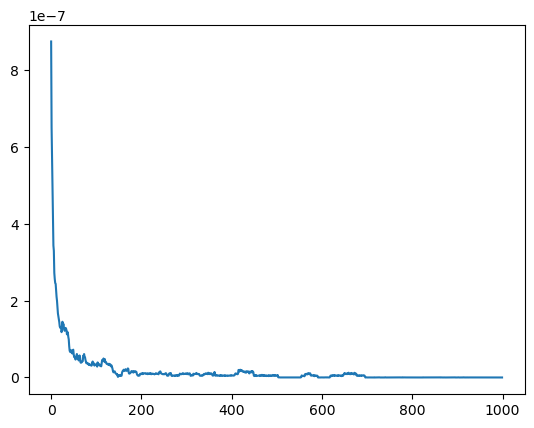

In [12]:
plt.plot(acceptance)

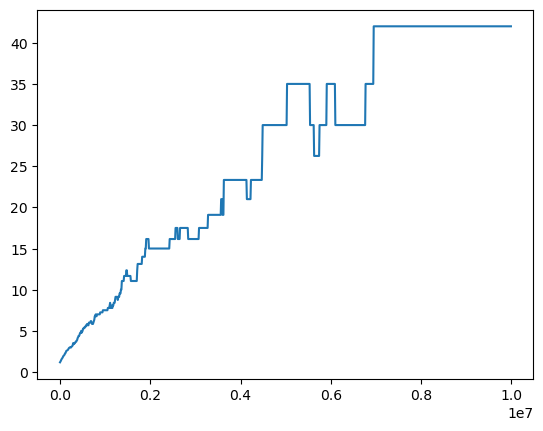

In [13]:
plt.plot([i*(step_tot//check_step) for i in range(check_step)],av_c_size)

In [14]:
mc.get_cluster_size()

array([48,  7, 87, 52, 16])

In [22]:
import pyvista as pv
def plot_simulation(mc, output_filename='simulation.html'):
    size = mc.size

    # Get DHH1 positions and convert to coordinates
    dhh1_positions = mc.get_DHH1_positions()
    dhh1_coords = np.array([to_xyz(pos, size) for pos in dhh1_positions])

    # Get RNA positions and convert to coordinates
    rna_positions_list = mc.get_RNA_positions()
    rna_coords_list = []
    for rna_positions in rna_positions_list:
        coords = np.array([to_xyz(pos, size) for pos in rna_positions])
        rna_coords_list.append(coords)

    # Generate lattice vertices
    lattice_vertices = generate_lattice_vertices(size)

    # Create a PyVista plotter
    plotter = pv.Plotter()

    # Add the box contour as a light black wireframe cube
    box_center = (size / 2 - 0.5, size / 2 - 0.5, size / 2 - 0.5)
    box = pv.Cube(center=box_center, x_length=size, y_length=size, z_length=size)
    plotter.add_mesh(box, color='black', opacity=0.2, style='wireframe', line_width=1)

    # Add lattice vertices as small black dots
    #lattice_points = pv.PolyData(lattice_vertices)
    #plotter.add_mesh(lattice_points, color='black', point_size=2.5, render_points_as_spheres=True)

    # Add DHH1 particles as points
    if dhh1_coords.size > 0:
        dhh1_points = pv.PolyData(dhh1_coords)
        plotter.add_mesh(dhh1_points, color='red', point_size=10.0, render_points_as_spheres=True)

    # Plot RNA polymers as segments
    for coords in rna_coords_list:
        if coords.size > 0:
            # Initialize lists to store line segments
            segments = []
            num_monomers = coords.shape[0]
            for i in range(-num_monomers+1,num_monomers - 1):
                p1 = coords[i]
                p2 = coords[i + 1]

                # Unwrap positions to account for periodic boundary conditions
                delta = p2 - p1
                for dim in range(3):
                    if delta[dim] > size / 2:
                        delta[dim] -= size
                    elif delta[dim] < -size / 2:
                        delta[dim] += size
                p2_unwrapped = p1 + delta

                # Check if the segment crosses the boundary
                if np.any(p2_unwrapped < 0) or np.any(p2_unwrapped > size - 1):
                    # Clip the segment at the box boundaries
                    clipped_segment = clip_segment_to_box(p1, p2_unwrapped, size)
                    if clipped_segment is not None:
                        segments.append(clipped_segment)
                else:
                    # Segment is inside the box, add it directly
                    segments.append(np.array([p1, p2_unwrapped]))
            # Plot the segments
            for segment in segments:
                line = pv.Line(segment[0], segment[1])
                plotter.add_mesh(line, color='blue', line_width=2)

            # Also add monomer points
            monomer_points = pv.PolyData(coords)
            plotter.add_mesh(monomer_points, color='blue', point_size=20.0, render_points_as_spheres=True)

    # Set plotter options
    plotter.set_background('white')
    plotter.show_axes()
    plotter.show_bounds(
    grid='front',          # Show grid on the front face
    location='outer',      # Place labels outside the bounding box
    all_edges=True,        # Show all edges of the grid
    xtitle='X Axis',       # Label for the X-axis
    ytitle='Y Axis',       # Label for the Y-axis
    ztitle='Z Axis'        # Label for the Z-axis
    )
    # Optional: Set the camera position
    plotter.view_isometric()

    # Save the plot as an HTML file
    plotter.export_html(output_filename)
def to_xyz(index, size):
    z = index % size
    y = (index // size) % size
    x = index // (size * size)
    return np.array([x, y, z])
def generate_lattice_vertices(size):
    # Generate all combinations of x, y, z in 0..size-1
    x = np.arange(size)
    y = np.arange(size)
    z = np.arange(size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
    return grid_points

In [23]:
plot_simulation(mc)

/media/hcleroy/anaconda3/lib/python3.11/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
